# Bayes

In de vorige sectie zagen we hoe we een uni-variaat regressie model van de data probabilistisch kunnen uitdrukken aan de hand van de {ref}`likelihood function <target-likelihood-function>`:

$$
p(\pmb{y}|\pmb{X}, \pmb{b}, \sigma) = \mathcal{N}(\pmb{X}\pmb{b}, \pmb{I}\sigma^2)
$$

In deze sectie bespreken we de uitbreiding naar {u}`Bayesiaanse parameterschatting`; een heel krachtig framework binnen ML. We zullen via een sterk vereenvoudigd regressiemodel het basisprincipe van Bayesiaanse parameterschatting illustreren. Voor een uitgebreidere uiteenzetting kan je onder andere terecht bij Bishop ([2006](https://github.com/Benlau93/Data-Science-Curriculum/blob/master/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf)).

:::{important}
Het is belangrijk om bij deze uiteenzetting de basisregels van probabiliteit goed voor ogen te houden:
1. Somregel:

$$
P(x) = \sum_y P(x, y)
$$

2. Productregel

$$
\begin{align}
P(x, y) &= P(y|x)P(x) \cr
&= P(x|y)P(y) \cr
P(x^{(1)}, \ldots, x^{(n)}) &= P(x^{(1)})\prod_{i=2}^{n}P(x^{(i)}|x^{(1)}, \ldots, x^{(i-1)})
\end{align}
$$
:::

## De regel van Bayes
(target-bayes-rule)=

De regel van Bayes is een centrale formulering in de probabilistische benadering van data modellering. De regel kan eenvoudig worden afgeleid uit de basisregels van probabiliteit. We beginnen bij de gezamenlijke distributie van onze (voor de eenvoud: uni-variate) observaties $\pmb{y}$ en de {ref}`parameters <target-parameters>` $\pmb{\theta}$ (de onbekende argumenten van onze modelfunctie).

$$
p(\pmb{y}, \pmb{X}, \pmb{\theta})
$$

De features $\pmb{X}$ laten we voor de eenvoud achterwege omdat we in standaard modellering ervan uitgaan dat deze zonder fout gemeten zijn en dus geen kansvariabelen zijn.

Via de productregel kunnen we deze _joint_ probability op _twee manieren schrijven_ in functie van de conditionele en marginale probabiliteit:

$$
p(\pmb{y}, \pmb{\theta}) = p(\pmb{\theta}|\pmb{y})p(\pmb{y})
$$

en

$$
p(\pmb{y}, \pmb{\theta}) = p(\pmb{y}|\pmb{\theta})p(\pmb{\theta})
$$

Als we deze formuleringen aan elkaar gelijk zetten krijgen we:

$$
p(\pmb{\theta}|\pmb{y})p(\pmb{y}) = p(\pmb{y}|\pmb{\theta})p(\pmb{\theta})
$$

:::{important} De regel van Bayes

$$
p(\pmb{\theta}|\pmb{y}) = \frac{p(\pmb{y}|\pmb{\theta})p(\pmb{\theta})}{p(\pmb{y})}
$$
:::

Elk van de termen heeft een specifieke betekenis.

### _Likelihood_ $p(\pmb{y}|\pmb{\theta})$
Deze term kennen we al. Deze drukt de kansverdeling uit van onze observaties $\pmb{y}$, _gegeven_ de _parameterwaarden_ $\pmb{\theta}$. Zoals we in de vorige sectie zagen kunnen we deze functie een specifieke invulling geven mits bepaalde aannames over de vorm van de variantie (bv. normaalverdeling) en onafhankelijkheid van de data.

### _Prior_ $p(\pmb{\theta})$
(target-bayes-prior)=
Dit is de marginale kansverdeling van onze parameters $\pmb{\theta}$. Ze drukt de kans uit op verschillende parameterwaarden in $\pmb{\theta}$, nog voor we ook nog maar een enkele observatie deden. We denken hier in de Bayesiaanse betekenis van kansen, dus _belief_. Dit impliceert dat de regel van Bayes toelaat om via een keuze voor de _Prior_ distributie aan bepaalde parameterwaarden meer of minder _geloof_ te hechten tijdens onze zoektocht naar optimale parameterwaarden! Hierdoor kunnen we op een natuurlijke manier voorafgaande kennis inbouwen (b.v. een factor 2.0 voor de verhouding tussen aankoopbedrag en fooi is veel minder aannemelijk dan een factor 0.01).

### _Posterior_ $p(\pmb{\theta}|\pmb{y})$
(target-bayes-posterior)=
Dit is de kansverdeling van onze parameters $\pmb{\theta}$, _gegeven_ de geobserveerde waarden voor $\pmb{y}$ (en de vaste features $\pmb{X}$ die we weglieten uit de notatie).

### _Marginal likelihood_ $p(\pmb{y})$
Dit is technisch gesproken de marginale kans van de observaties. In de praktijk wordt deze term meestal genegeerd omdat die louter dient om ervoor te zorgen dat de noemer $p(\pmb{y}|\pmb{\theta})p(\pmb{\theta})$ integreert tot $1$ en dus als een _probability mass_ verdeling kwalificeert. De regel wordt bijgevolg ook vaak proportioneel[^prop] geformuleerd:

$$
p(\pmb{\theta}|\pmb{y}) \propto p(\pmb{y}|\pmb{\theta})p(\pmb{\theta})
$$
[^prop]: $\propto$ betekent "proportioneel aan"

## Bayesiaanse parameterschatting

Hieronder illustreren we de intuïtie van Bayesiaanse parameterschatting met de gekende {ref}`koffiehuis simulatie <target-coffee-simulation>`. We tonen hoe we via dit mechanisme optimale parameterwaarden kunnen vinden door sequentieel meer data te observeren. We maken de assumptie dat we enkel op zoek zijn naar de lineaire gewichten $b_1$ en $b_2$ en de waarden van $\sigma=0.30$ reeds kennen[^bishop].

[^bishop]: zie bijvoorbeeld Bishop [2006](https://github.com/Benlau93/Data-Science-Curriculum/blob/master/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf) voor een complete behandeling van een Bayesiaanse uitwerking van lineaire regressie.

### _Prior_
Wanneer we nog geen data hebben (start van de training), kunnen we wel al een distributie van de parameters kiezen aan de hand van de _prior_. Hier kiezen we voor een bi-variate normaalverdeling met gemiddelde $\pmb{0}$, homogene variantie $\sigma^2=0.25$ en covariantie $0$: $\mathcal{N}(\pmb{0}, 0.25\pmb{I})$. Hieronder visualiseren we de bivariate verdeling met een aantal gesampelde waarden in de $(\pmb{x}, \pmb{y})$-ruimte.

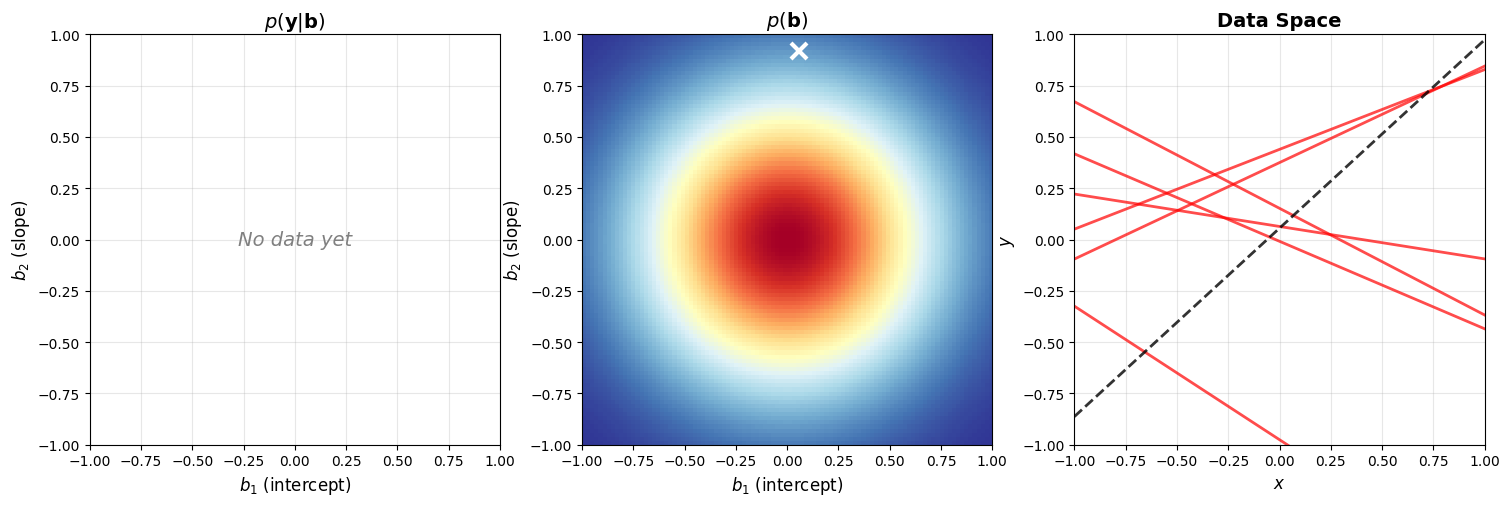

<Figure size 640x480 with 0 Axes>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal

from ml_courses.sim.monte_carlo_tips import MonteCarloTipsSimulation

# Generate data
sim = MonteCarloTipsSimulation(n_customers=20, seed=12)

# Standardize the data (center and scale)
x_mean = np.mean(sim.order_totals)
x_std = np.std(sim.order_totals)
y_mean = np.mean(sim.observed_tips)
y_std = np.std(sim.observed_tips)

x_centered = (sim.order_totals - x_mean) / x_std
y_centered = (sim.observed_tips - y_mean) / y_std

# Known noise std in standardized space (approximate)
beta = 1 / (0.3**2)  # precision parameter

# Calculate true parameters in standardized space
# True model: y = true_b1 + true_b2 * x
# In standardized space: y_std = b1_std + b2_std * x_std
# where y_centered = (y - y_mean) / y_std and x_centered = (x - x_mean) / x_std
# So: (y - y_mean) / y_std = b1_std + b2_std * (x - x_mean) / x_std
# y = y_mean + y_std * b1_std + (y_std * b2_std / x_std) * (x - x_mean)
# y = (y_mean - y_std * b2_std * x_mean / x_std + y_std * b1_std) + (y_std * b2_std / x_std) * x
true_b1_standardized = (sim.true_b1 - y_mean + sim.true_b2 * x_mean) / y_std
true_b2_standardized = sim.true_b2 * x_std / y_std

# Set random seed for reproducibility
rng = np.random.default_rng(42)

# Create figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Left plot: Likelihood (empty for now)
axes[0].set_xlabel("$b_1$ (intercept)", fontsize=12)
axes[0].set_ylabel("$b_2$ (slope)", fontsize=12)
axes[0].set_title(r"$p(\mathbf{y}|\mathbf{b})$", fontsize=14, fontweight="bold")
axes[0].set_xlim(-1, 1)
axes[0].set_ylim(-1, 1)
axes[0].set_aspect("equal")
axes[0].grid(True, alpha=0.3)
axes[0].text(
    0, 0, "No data yet", ha="center", va="center", fontsize=14, style="italic", color="gray"
)

# Middle plot: Joint prior distribution (bivariate normal with mean 0, std 0.3)
b0_range = np.linspace(-1, 1, 100)
b1_range = np.linspace(-1, 1, 100)
B0, B1 = np.meshgrid(b0_range, b1_range)

# Bivariate normal prior: N(0, 0.25 * I)
mean = [0, 0]
cov = [[0.25, 0], [0, 0.25]]  # Independent priors with std=0.5
prior_dist = multivariate_normal(mean=mean, cov=cov)

# Evaluate the prior density on the grid
pos = np.dstack((B0, B1))
prior_density = prior_dist.pdf(pos)

# Plot the prior as a heatmap
im = axes[1].imshow(
    prior_density, extent=[-1, 1, -1, 1], origin="lower", cmap="RdYlBu_r", aspect="equal"
)
# Mark the true parameter values
axes[1].plot(
    true_b1_standardized,
    true_b2_standardized,
    "x",
    color="white",
    markersize=12,
    markeredgewidth=3,
    label="True parameters",
)
axes[1].set_xlabel("$b_1$ (intercept)", fontsize=12)
axes[1].set_ylabel("$b_2$ (slope)", fontsize=12)
axes[1].set_title(r"$p(\mathbf{b})$", fontsize=14, fontweight="bold")
axes[1].grid(False)

# Right plot: Sample regression lines from the prior
x_range = np.linspace(-1, 1, 100)

# Sample several parameter pairs from the normal prior
n_samples = 6
samples = rng.multivariate_normal(mean, cov, size=n_samples)

for i in range(n_samples):
    b0_sample = samples[i, 0]
    b1_sample = samples[i, 1]

    # Compute the regression line
    y_line = b0_sample + b1_sample * x_range

    # Plot the line
    axes[2].plot(x_range, y_line, "r-", alpha=0.7, linewidth=2)

# Plot the true relationship
y_true = true_b1_standardized + true_b2_standardized * x_range
axes[2].plot(x_range, y_true, "k--", linewidth=2, label="True relationship", alpha=0.8)

axes[2].set_xlabel("$x$", fontsize=12)
axes[2].set_ylabel("$y$", fontsize=12)
axes[2].set_title("Data Space", fontsize=14, fontweight="bold")
axes[2].set_xlim(-1, 1)
axes[2].set_ylim(-1, 1)
axes[2].set_aspect("equal")
axes[2].grid(True, alpha=0.3)

plt.show()
plt.tight_layout()

### +1 _Posterior_
Van zodra we één datapunt $(x, y)$ observeren, kunnen we daarvan de _likelihood_ berekenen: de kans, gegeven verschillende waarden voor $\pmb{b}$. Als we die _likelihood_ vermenigvuldigen met de initiële _prior_, krijgen we de _posterior_ na één observatie. Als we hier zouden stoppen en de maximale _posterior_ (de zogenaamde MAP) locatie kiezen voor de parameters, zitten we duidelijk nog veraf van de werkelijke waarde (zie wit kruisje).

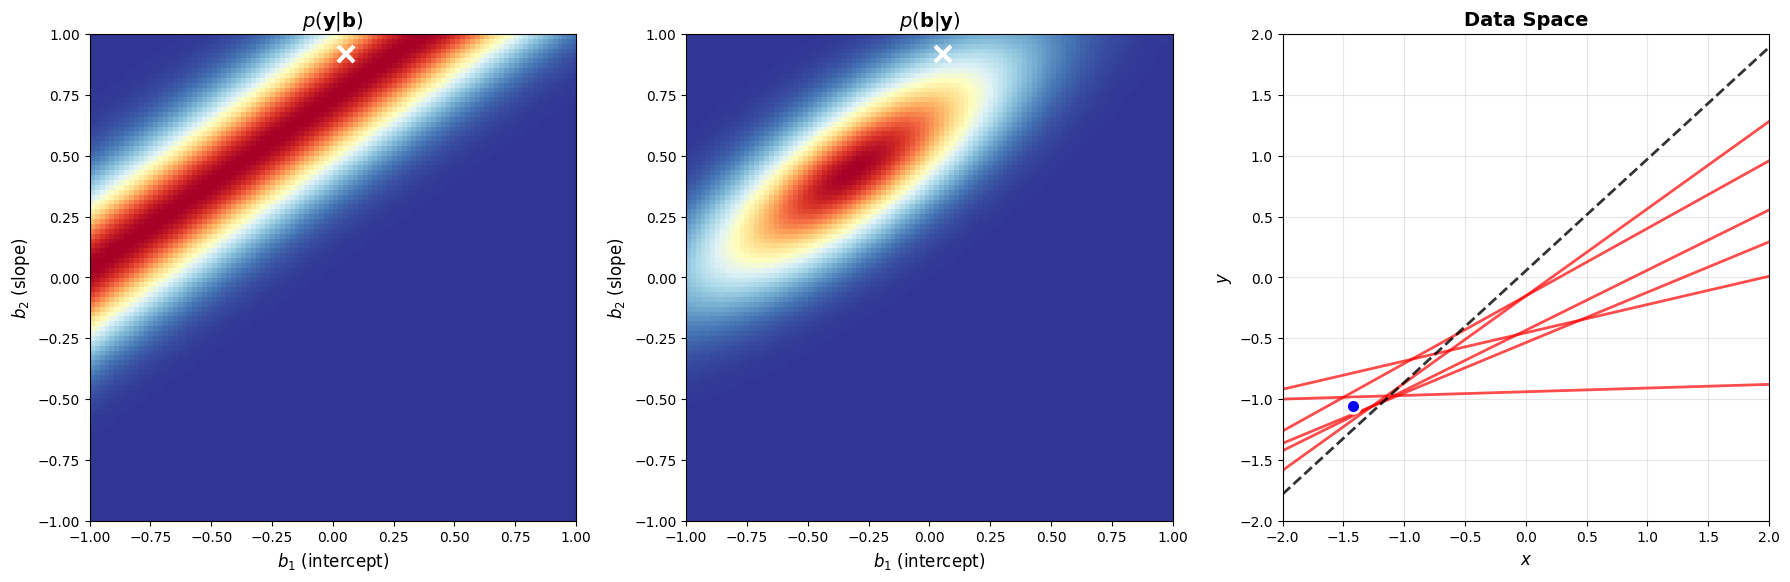

In [2]:
# Observation 1: After observing the first data point
n_obs = 1
x_obs = x_centered[:n_obs]
y_obs = y_centered[:n_obs]

# Create figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Left plot: Likelihood function for the first data point
# For a single data point, likelihood is proportional to exp(-beta/2 * (y - (b0 + b1*x))^2)
b0_range = np.linspace(-1, 1, 100)
b1_range = np.linspace(-1, 1, 100)
B0, B1 = np.meshgrid(b0_range, b1_range)

# Calculate likelihood for the observed data point
x_val = x_obs[0]
y_val = y_obs[0]
likelihood = np.exp(-beta / 2 * (y_val - (B0 + B1 * x_val)) ** 2)

# Plot the likelihood as a heatmap
im = axes[0].imshow(
    likelihood, extent=[-1, 1, -1, 1], origin="lower", cmap="RdYlBu_r", aspect="equal"
)
# Mark the true parameter values
axes[0].plot(
    true_b1_standardized,
    true_b2_standardized,
    "x",
    color="white",
    markersize=12,
    markeredgewidth=3,
    label="True parameters",
)
axes[0].set_xlabel("$b_1$ (intercept)", fontsize=12)
axes[0].set_ylabel("$b_2$ (slope)", fontsize=12)
axes[0].set_title(r"$p(\mathbf{y}|\mathbf{b})$", fontsize=14, fontweight="bold")
axes[0].grid(False)

# Middle plot: Posterior distribution (prior × likelihood)
posterior = prior_density * likelihood
# Normalize the posterior
posterior = posterior / (
    np.sum(posterior) * (b0_range[1] - b0_range[0]) * (b1_range[1] - b1_range[0])
)

im = axes[1].imshow(
    posterior, extent=[-1, 1, -1, 1], origin="lower", cmap="RdYlBu_r", aspect="equal"
)
# Mark the true parameter values
axes[1].plot(
    true_b1_standardized,
    true_b2_standardized,
    "x",
    color="white",
    markersize=12,
    markeredgewidth=3,
    label="True parameters",
)
axes[1].set_xlabel("$b_1$ (intercept)", fontsize=12)
axes[1].set_ylabel("$b_2$ (slope)", fontsize=12)
axes[1].set_title(r"$p(\mathbf{b}|\mathbf{y})$", fontsize=14, fontweight="bold")
axes[1].grid(False)

# Right plot: Sample regression lines from the posterior + data points
x_plot_range = np.linspace(-2, 2, 100)

# Sample from posterior by sampling from the grid weighted by posterior probability
# Flatten the posterior and sample indices
posterior_flat = posterior.flatten()
posterior_flat = posterior_flat / np.sum(posterior_flat)
n_samples = 6
sample_indices = rng.choice(len(posterior_flat), size=n_samples, p=posterior_flat)

for idx in sample_indices:
    i = idx // len(b0_range)
    j = idx % len(b0_range)
    b0_sample = b0_range[j]
    b1_sample = b1_range[i]

    # Compute the regression line
    y_line = b0_sample + b1_sample * x_plot_range

    # Plot the line
    axes[2].plot(x_plot_range, y_line, "r-", alpha=0.7, linewidth=2)

# Plot the observed data point
axes[2].plot(
    x_obs,
    y_obs,
    "o",
    color="blue",
    markersize=10,
    markeredgecolor="white",
    markeredgewidth=2,
    label="Observed data",
)

# Plot the true relationship
y_true = true_b1_standardized + true_b2_standardized * x_plot_range
axes[2].plot(x_plot_range, y_true, "k--", linewidth=2, label="True relationship", alpha=0.8)

axes[2].set_xlabel("$x$", fontsize=12)
axes[2].set_ylabel("$y$", fontsize=12)
axes[2].set_title("Data Space", fontsize=14, fontweight="bold")
axes[2].set_xlim(-2, 2)
axes[2].set_ylim(-2, 2)
axes[2].set_aspect("equal")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### +2 _Posterior_
Nu voegen we een tweede observatie toe. We berekenen opnieuw de _likelihood_ voor deze afzonderlijke observatie, maar om de _posterior_ te berekenen, vermenigvuldigen we die nu niet met de originele _prior_, maar met de _posterior_ van de vorige stap. We beschouwen die dus als een nieuwe _prior_, met ingebouwde kennis over de eerste observatie.

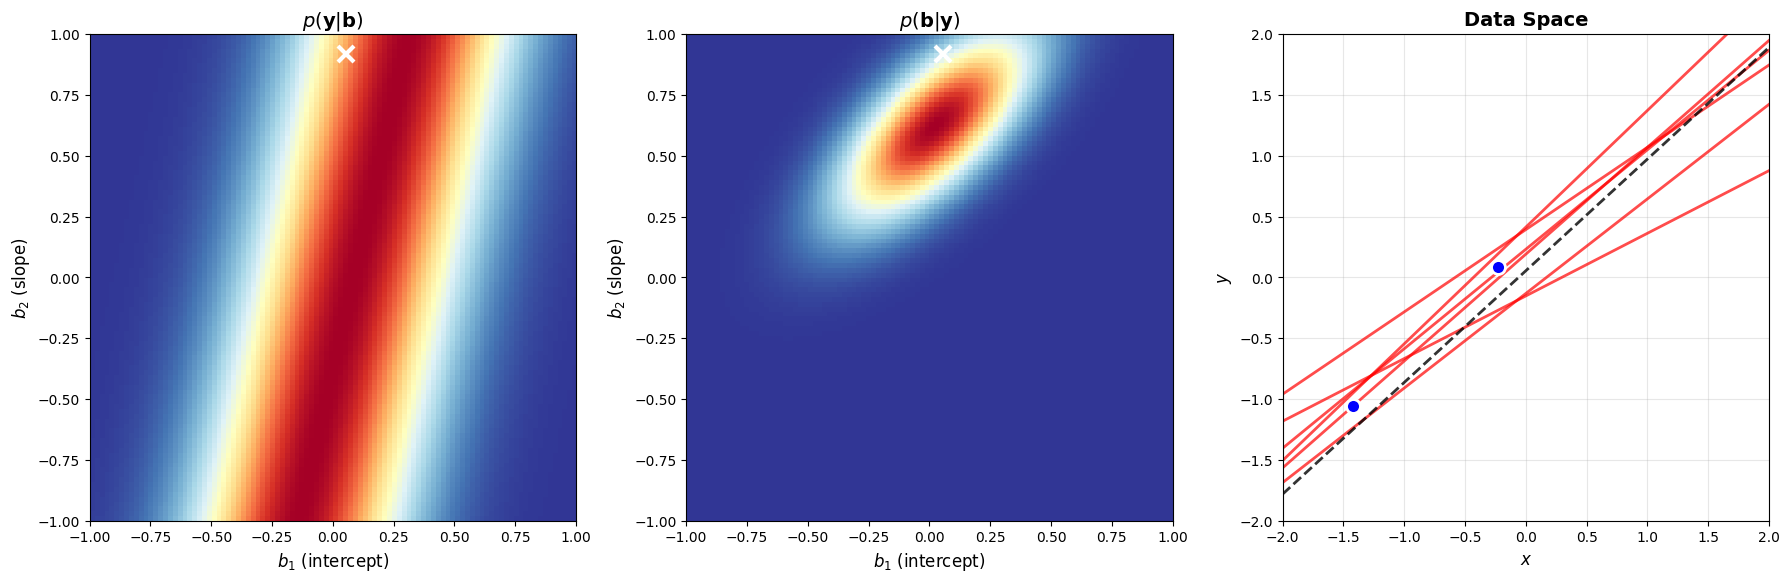

In [3]:
# Observation 2: After observing the second data point
n_obs = 2
x_obs = x_centered[[0, 10]]
y_obs = y_centered[[0, 10]]

# Create figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Left plot: Likelihood function for the second data point
# Calculate likelihood for the second observed data point
x_val = x_obs[1]
y_val = y_obs[1]
likelihood = np.exp(-beta / 2 * (y_val - (B0 + B1 * x_val)) ** 2)

# Plot the likelihood as a heatmap
im = axes[0].imshow(
    likelihood, extent=[-1, 1, -1, 1], origin="lower", cmap="RdYlBu_r", aspect="equal"
)
# Mark the true parameter values
axes[0].plot(
    true_b1_standardized,
    true_b2_standardized,
    "x",
    color="white",
    markersize=12,
    markeredgewidth=3,
    label="True parameters",
)
axes[0].set_xlabel("$b_1$ (intercept)", fontsize=12)
axes[0].set_ylabel("$b_2$ (slope)", fontsize=12)
axes[0].set_title(r"$p(\mathbf{y}|\mathbf{b})$", fontsize=14, fontweight="bold")
axes[0].grid(False)

# Middle plot: New posterior (previous posterior × new likelihood)
# The posterior from the previous step becomes the prior
new_posterior = posterior * likelihood
# Normalize the posterior
new_posterior = new_posterior / (
    np.sum(new_posterior) * (b0_range[1] - b0_range[0]) * (b1_range[1] - b1_range[0])
)

im = axes[1].imshow(
    new_posterior, extent=[-1, 1, -1, 1], origin="lower", cmap="RdYlBu_r", aspect="equal"
)
# Mark the true parameter values
axes[1].plot(
    true_b1_standardized,
    true_b2_standardized,
    "x",
    color="white",
    markersize=12,
    markeredgewidth=3,
    label="True parameters",
)
axes[1].set_xlabel("$b_1$ (intercept)", fontsize=12)
axes[1].set_ylabel("$b_2$ (slope)", fontsize=12)
axes[1].set_title(r"$p(\mathbf{b}|\mathbf{y})$", fontsize=14, fontweight="bold")
axes[1].grid(False)

# Right plot: Sample regression lines from the new posterior + data points
x_plot_range = np.linspace(-2, 2, 100)

# Sample from new posterior by sampling from the grid weighted by posterior probability
new_posterior_flat = new_posterior.flatten()
new_posterior_flat = new_posterior_flat / np.sum(new_posterior_flat)
n_samples = 6
sample_indices = rng.choice(len(new_posterior_flat), size=n_samples, p=new_posterior_flat)

for idx in sample_indices:
    i = idx // len(b0_range)
    j = idx % len(b0_range)
    b0_sample = b0_range[j]
    b1_sample = b1_range[i]

    # Compute the regression line
    y_line = b0_sample + b1_sample * x_plot_range

    # Plot the line
    axes[2].plot(x_plot_range, y_line, "r-", alpha=0.7, linewidth=2)

# Plot the observed data points (both)
axes[2].plot(
    x_obs,
    y_obs,
    "o",
    color="blue",
    markersize=10,
    markeredgecolor="white",
    markeredgewidth=2,
    label="Observed data",
)

# Plot the true relationship
y_true = true_b1_standardized + true_b2_standardized * x_plot_range
axes[2].plot(x_plot_range, y_true, "k--", linewidth=2, label="True relationship", alpha=0.8)

axes[2].set_xlabel("$x$", fontsize=12)
axes[2].set_ylabel("$y$", fontsize=12)
axes[2].set_title("Data Space", fontsize=14, fontweight="bold")
axes[2].set_xlim(-2, 2)
axes[2].set_ylim(-2, 2)
axes[2].set_aspect("equal")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### +N _Posterior_
Als we dit proces herhalen tot we alle data "gezien" hebben, krijgen we de volgende oplossing. We starten opnieuw vanaf de originele _prior_ en updaten sequentieel door alle 20 observaties, waarbij we telkens de _posterior_ doorschuiven naar de _prior_ om onze kennis op te bouwen. Als we nu naar het MAP-coördinaat kijken en de onzekerheid daarover, is het resultaat zeer bevredigend! Hoewel dit een sterk vereenvoudigd scenario van Bayesiaanse parameterschatting is, ligt in deze illustratie de kern van deze flexibele en krachtige benadering in ML.

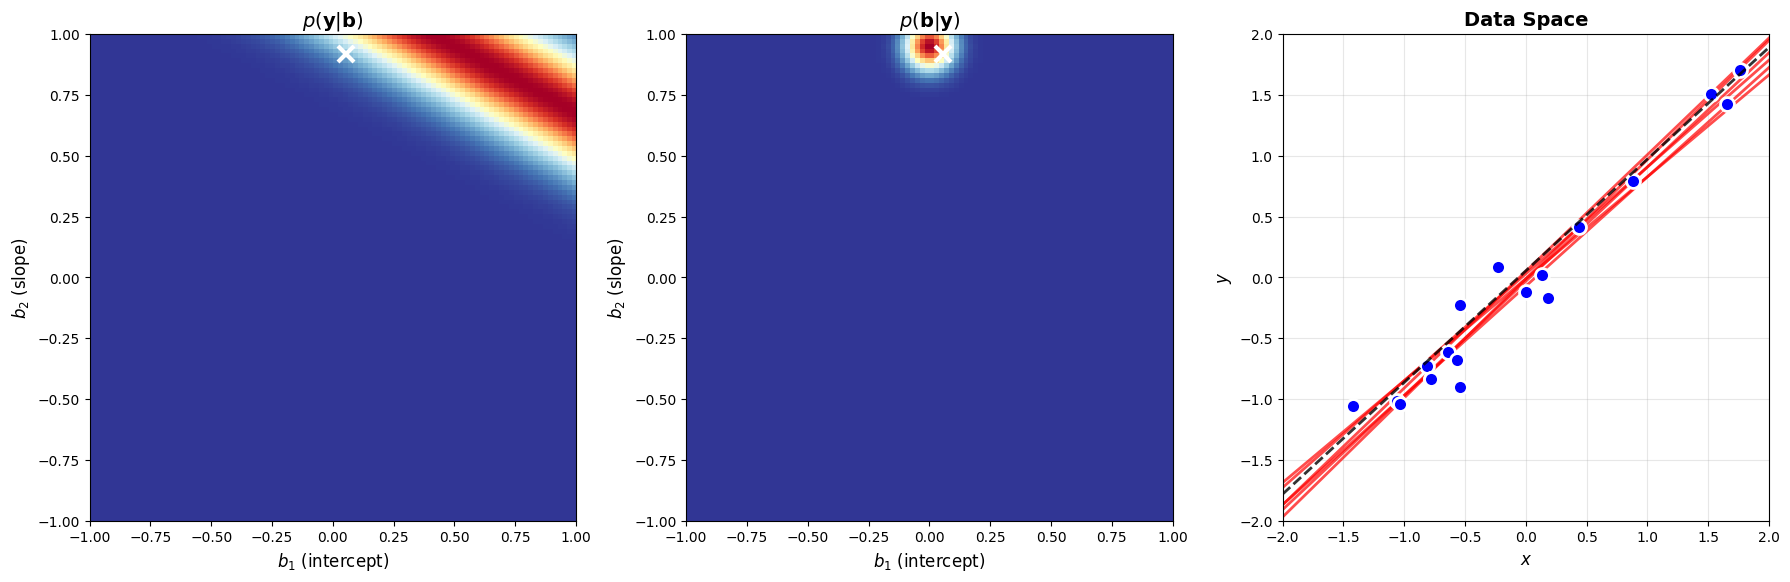

In [4]:
# Process all 20 observations sequentially
n_obs = 20
x_obs = x_centered[:n_obs]
y_obs = y_centered[:n_obs]

# Start with the original prior
current_posterior = prior_density.copy()

# Create figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Sequentially update the posterior with each observation
for i in range(n_obs):
    x_val = x_obs[i]
    y_val = y_obs[i]

    # Calculate likelihood for this data point
    likelihood = np.exp(-beta / 2 * (y_val - (B0 + B1 * x_val)) ** 2)

    # Update posterior: posterior = prior × likelihood
    current_posterior = current_posterior * likelihood

    # Normalize
    current_posterior = current_posterior / (
        np.sum(current_posterior) * (b0_range[1] - b0_range[0]) * (b1_range[1] - b1_range[0])
    )

# Left plot: Likelihood function for the last data point
x_val = x_obs[-1]
y_val = y_obs[-1]
likelihood_last = np.exp(-beta / 2 * (y_val - (B0 + B1 * x_val)) ** 2)

im = axes[0].imshow(
    likelihood_last, extent=[-1, 1, -1, 1], origin="lower", cmap="RdYlBu_r", aspect="equal"
)
# Mark the true parameter values
axes[0].plot(
    true_b1_standardized,
    true_b2_standardized,
    "x",
    color="white",
    markersize=12,
    markeredgewidth=3,
    label="True parameters",
)
axes[0].set_xlabel("$b_1$ (intercept)", fontsize=12)
axes[0].set_ylabel("$b_2$ (slope)", fontsize=12)
axes[0].set_title(r"$p(\mathbf{y}|\mathbf{b})$", fontsize=14, fontweight="bold")
axes[0].grid(False)

# Middle plot: Final posterior after all observations
im = axes[1].imshow(
    current_posterior, extent=[-1, 1, -1, 1], origin="lower", cmap="RdYlBu_r", aspect="equal"
)
# Mark the true parameter values
axes[1].plot(
    true_b1_standardized,
    true_b2_standardized,
    "x",
    color="white",
    markersize=12,
    markeredgewidth=3,
    label="True parameters",
)
axes[1].set_xlabel("$b_1$ (intercept)", fontsize=12)
axes[1].set_ylabel("$b_2$ (slope)", fontsize=12)
axes[1].set_title(r"$p(\mathbf{b}|\mathbf{y})$", fontsize=14, fontweight="bold")
axes[1].grid(False)

# Right plot: Sample regression lines from the final posterior + all data points
x_plot_range = np.linspace(-2, 2, 100)

# Sample from final posterior
final_posterior_flat = current_posterior.flatten()
final_posterior_flat = final_posterior_flat / np.sum(final_posterior_flat)
n_samples = 6
sample_indices = rng.choice(len(final_posterior_flat), size=n_samples, p=final_posterior_flat)

for idx in sample_indices:
    i = idx // len(b0_range)
    j = idx % len(b0_range)
    b0_sample = b0_range[j]
    b1_sample = b1_range[i]

    # Compute the regression line
    y_line = b0_sample + b1_sample * x_plot_range

    # Plot the line
    axes[2].plot(x_plot_range, y_line, "r-", alpha=0.7, linewidth=2)

# Plot all observed data points
axes[2].plot(
    x_obs,
    y_obs,
    "o",
    color="blue",
    markersize=10,
    markeredgecolor="white",
    markeredgewidth=2,
    label="Observed data",
)

# Plot the true relationship
y_true = true_b1_standardized + true_b2_standardized * x_plot_range
axes[2].plot(x_plot_range, y_true, "k--", linewidth=2, label="True relationship", alpha=0.8)

axes[2].set_xlabel("$x$", fontsize=12)
axes[2].set_ylabel("$y$", fontsize=12)
axes[2].set_title("Data Space", fontsize=14, fontweight="bold")
axes[2].set_xlim(-2, 2)
axes[2].set_ylim(-2, 2)
axes[2].set_aspect("equal")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()